In [236]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import simplex_diffuser
import seaborn as sns
import tree
from data import rosetta_data_loader
from experiments import train_se3_diffusion
from experiments import inference_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [237]:
importlib.reload(simplex_diffuser)

<module 'data.simplex_diffuser' from '/data/rsg/chemistry/jyim/projects/protein_diffusion/data/simplex_diffuser.py'>

In [382]:
def calc_perplexity(pred, labels):
    true_probs = np.sum(pred * labels, axis=-1)
    # ce = np.mean(-np.log(true_probs), axis=0)
    ce = -np.log(np.mean(true_probs, axis=0))
    perplexity = np.mean(np.exp(ce))
    return perplexity

    # label_preds = pred[np.nonzero(labels)]
    # perplexity = np.exp(-np.log(label_preds))
    # return np.mean(perplexity)

def calc_label_prob(pred, labels):
    label_prob = pred[np.nonzero(labels)]
    return np.mean(label_prob)

In [388]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'rosetta'
exp_conf.ckpt_dir = None
exp_conf.num_loader_workers = 1
exp_conf.dist_mode = 'single'
exp_conf.use_wandb = False

# Data settings
data_conf = conf.data
data_conf.rosetta.filtering.subset = 1
data_conf.rosetta.filtering.max_len = 80

# Diffusion settings
diff_conf = conf.diffuser
# diff_conf.seq.schedule = 'linear'
diff_conf.seq.min_b = 7.5
diff_conf.seq.max_b = 20.0

# Figure out data loading for PDB on rosetta
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, valid_loader = exp.create_rosetta_dataset(0, 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
exp._model = exp._model.to(device)

INFO: Number of model parameters 17602539
INFO: Using cached IGSO3.
INFO: Checkpoint not being saved.
INFO: Evaluation saved to: ./results/baseline/13D_10M_2022Y_23h_14m_35s
INFO: Training: 1 examples
INFO: Validation: 4 examples with lengths [64 64 64 64 64 64 64 64 64 64]


In [389]:
train_iter = iter(train_loader)
next_item = next(train_iter)

b_idx = 4
aatype = next_item['aatype'][b_idx]
res_mask = next_item['res_mask'][b_idx]
fixed_mask = next_item['fixed_mask'][b_idx]
diffused_mask = 1 - fixed_mask
# print(aatype)
# print(torch.where(diffused_mask)[0])
# print(next_item['t'][b_idx])
# torch.argmax(next_item['aatype_t'][b_idx], dim=-1)
# next_item['aatype_t'][b_idx][0]

In [391]:
unpad_aatype = du.move_to_np(aatype[res_mask.bool()])
seq_diff = exp.diffuser.seq_diffuser
one_hot_aatype = seq_diff.one_hot(unpad_aatype)
num_samples = 100
one_hot_aatype = np.tile(one_hot_aatype[None], (num_samples, 1, 1))
num_t = 100
ts = np.linspace(1e-3, 1.0, num_t)
all_samples = []
all_perplexities = []
all_probabilities = []
for t in ts:
    sample_t = seq_diff.forward_marginal(one_hot_aatype, t)['noisy_aatype']
    all_samples.append(sample_t)
    all_perplexities.append(
        calc_perplexity(sample_t, one_hot_aatype))
    all_probabilities.append(
        calc_label_prob(sample_t, one_hot_aatype))
avg_probs = np.stack([np.mean(x, axis=0) for x in all_samples], axis=0)
# seq_diff.forward_marginal(one_hot_aatype, 1.0)['noisy_aatype'][1, 1]
# seq_diff.forward_marginal(one_hot_aatype, 0.0)['aatype_sde'][0, 1]

Text(0, 0.5, 'Perplexity')

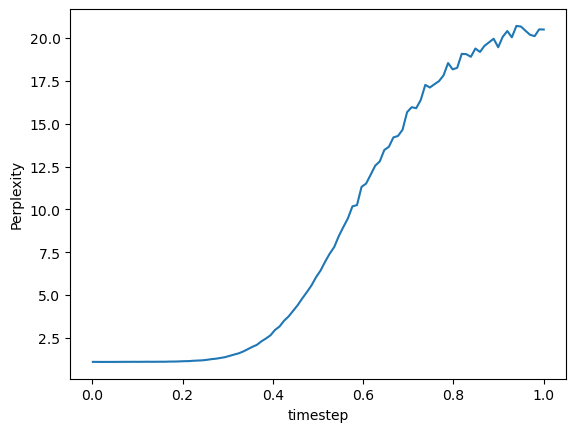

In [392]:
plt.plot(ts, all_perplexities)
plt.xlabel('timestep')
plt.ylabel('Perplexity')
# plt.title('Probability of true sequence during forward sequence diffusion')

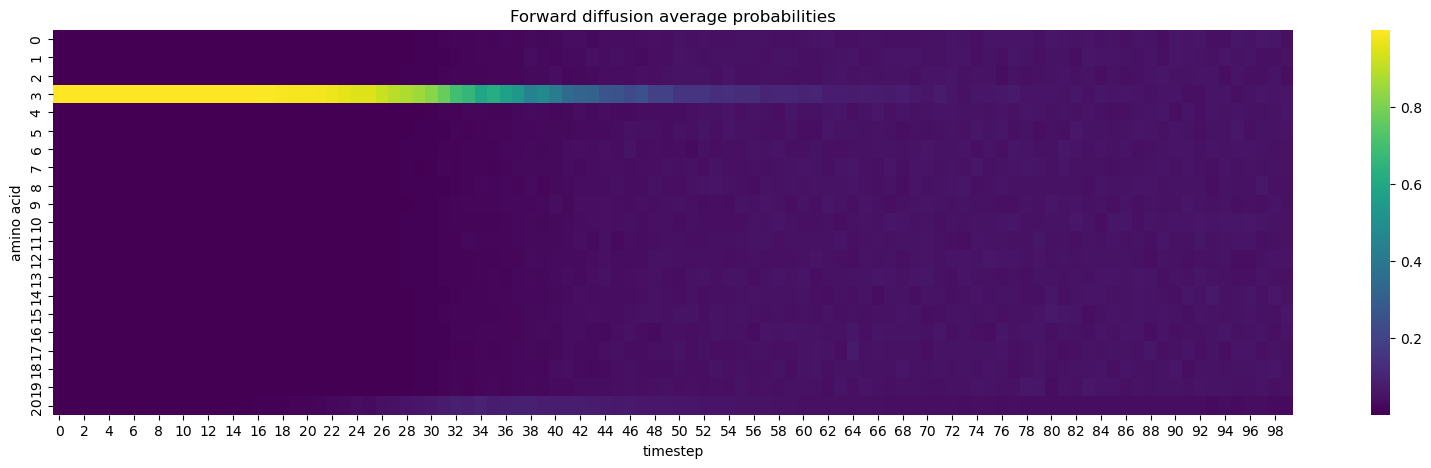

In [393]:
plt.figure(figsize=(20,5))
ax = sns.heatmap(avg_probs[:, 2, :].T, cmap='viridis')
_ = ax.set_xlabel('timestep')
_ = ax.set_ylabel('amino acid')
_ = ax.set_title('Forward diffusion average probabilities')

Text(0.5, 1.0, 'Probability of true sequence during forward sequence diffusion')

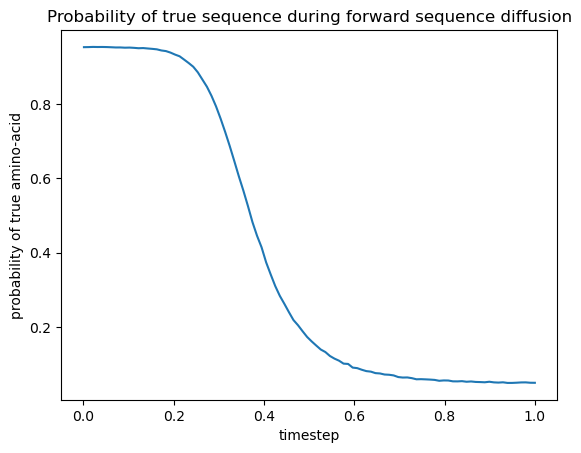

In [394]:
plt.plot(ts, all_probabilities)
plt.xlabel('timestep')
plt.ylabel('probability of true amino-acid')
plt.title('Probability of true sequence during forward sequence diffusion')

In [75]:
calc_perplexity(all_samples[-1], one_hot_aatype)

8.359864827723841

In [ ]:
# Plot the perplexity at each t
seq_diff.forward_marginal

In [4]:
import numpy as np
import math
import torch
from scipy.special import logit
from scipy.special import expit as logistic
from scipy.stats import multivariate_normal
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import ternary

In [ ]:
min_b = 0.1
max_b = 20.0
def b(t):
    return t*min_b + (1/2)*(t**2)*(max_b-min_b)

t = 0.9
x_0 = np.eye(3)[0]
mu = np.exp(-1/2*b(t)) * x_0
var = 1 - np.exp(-b(t))
plot_simplex(mu, var)

In [ ]:
def plot_simplex(mu, var):
    mvn = multivariate_normal(mu, var)
    def logit_normal_pdf(p):
        # Transform into multivariate gaussian
        p = np.array(p)
        x = logistic(p)
        return mvn.pdf(x)
    scale = 30
    figure, tax = ternary.figure(scale=scale)
    tax.heatmapf(logit_normal_pdf, boundary=False, style="triangular")
    tax.boundary(linewidth=2.0)
    tax.set_title("Logits-normal")
    tax.show()

In [ ]:
plot_simplex(1)

In [68]:
restypes = [
    'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P',
    'S', 'T', 'W', 'Y', 'V'
]

In [69]:
len(restypes)

20

In [70]:
restypes[19]

'V'

In [7]:
min_b = 0.1
max_b = 15.0
def b(t):
    return t*min_b + (1/2)*(t**2)*(max_b-min_b)

scale = 30
fig, tax = ternary.figure(scale=scale)
num_t = 100
ts = np.linspace(1e-3, 1.0, num_t)

def plot_simplex(i):
    t = ts[i]
    x_0 = np.eye(3)[0]
    mu = np.exp(-1/2*b(t)) * x_0
    var = 1 - np.exp(-b(t))
    mvn = multivariate_normal(mu, var)
    def logit_normal_pdf(p):
        # Transform into multivariate gaussian
        p = np.array(p)
        x = logistic(p)
        return mvn.pdf(x)
    tax.heatmapf(
        logit_normal_pdf,
        boundary=True,
        style="triangular",
        colorbar=False)
    tax.boundary(linewidth=2.0)
    tax.set_title(f'Simplex diffusion t={t:.4f}')

def update(frame):
    tax.close()
    _ =  plot_simplex(frame)

plot_simplex(0)
anim = FuncAnimation(
    fig,
    update,
    frames=list(range(1, num_t)),
    interval=10,
    blit=False)
writergif = animation.PillowWriter(fps=30)
save_path = f'simplex_diffusion_linear_minb_{min_b}_maxb_{max_b}.gif'
anim.save(save_path, writer=writergif)

### Simplex diffuser class

In [56]:
x_0 = np.eye(20)[0]
# x_0 = np.zeros_like(x_0)

In [59]:
x_0

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [65]:
min_b = 0.1
max_b = 20.0
def b(t):
    return t*min_b + (1/2)*(t**2)*(max_b-min_b)

t = 1.0
x_t = np.random.normal(
    loc=np.exp(-1/2*b(t)) * x_0,
    scale=np.sqrt(1 - np.exp(-b(t)))
)
exp_x_t = np.concatenate([np.exp(x_t), np.array([1.0])]) / (1 + np.sum(np.exp(x_t)))
exp_x_t

array([0.02066836, 0.01662281, 0.01078764, 0.05670665, 0.14920168,
       0.01738793, 0.07572645, 0.05901159, 0.01951077, 0.08604732,
       0.01008881, 0.04045653, 0.02898527, 0.01607936, 0.18563185,
       0.04814904, 0.06741189, 0.02365585, 0.01553152, 0.02339176,
       0.02894691])

In [66]:
exp_x_t = np.concatenate([np.exp(x_t), np.array([1.0])]) / (1 + np.sum(np.exp(x_t)))

In [22]:
exp_x_t

array([0.50675705, 0.18315034, 0.14362313, 0.16646947])

In [54]:
np.eye(21)[np.array([1, 4, 2])].shape

(3, 21)